In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read prepared B data for track-based SS

In [2]:
import pandas
Bdata = pandas.read_csv('models/Bdata_tracks_SS.csv')

In [3]:
Bdata.head()

,Bsign,Bweight,event_id,track_relation_prob
0,1,1.091776,0,0.901209
1,1,-0.417194,2,0.928010
2,-1,1.044602,3,1.087410
3,-1,1.062837,4,0.987712
4,1,1.076036,6,0.900421


### Obtain one weight column

In [4]:
# for Nan put 1 as non influence factor
Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.

In [5]:
relation_prob = Bdata['track_relation_prob'].values
Bprob = relation_prob / (1 + relation_prob)
Bweight = Bdata.Bweight.values
Bsign = Bdata.Bsign.values

In [6]:
Bprob[~numpy.isfinite(Bprob)] = 0.5

## 2-folding calibration by isotonic

In [7]:
from utils import calibrate_probs
Bprob_calibrated, (iso_reg1, iso_reg2) = calibrate_probs(Bsign, Bweight, Bprob,
                                                         symmetrize=True, return_calibrator=True)

#### Add some small noise in prediction for stability

In [8]:
Bprob_calibrated = Bprob_calibrated + numpy.random.normal(size=len(Bprob_calibrated)) * 0.001

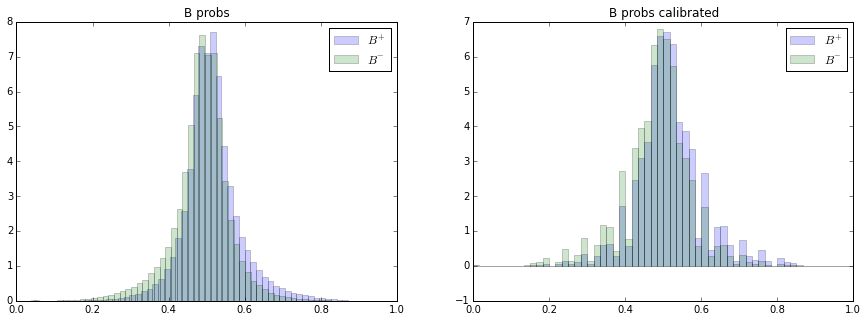

In [9]:
figure(figsize=(15, 5))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
hist(Bprob[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
legend(), title('B probs')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2, 
     normed=True, range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2,
     normed=True, range=(0, 1), label='$B^-$')
legend(), title('B probs calibrated')
plt.savefig('img/Bprob_iso_calibrated_SS.png' , format='png')

## AUC score and ROC curve for B+ vs B-

AUC for tagged: 0.593953484677 AUC with untag: 0.574189996756


((0, 1), (0, 1))

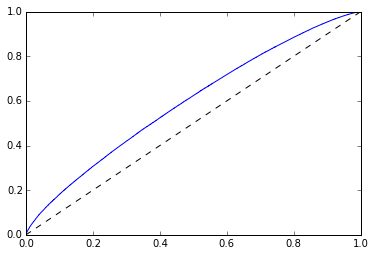

In [10]:
from utils import calculate_auc_with_and_without_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

fpr, tpr, _ = roc_curve(Bsign, Bprob_calibrated, sample_weight=Bweight)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)

## Symmetry $B^+$ vs $B^-$ checking

### before calibration

(<matplotlib.legend.Legend at 0x9f6c210>, <matplotlib.text.Text at 0x96cc990>)

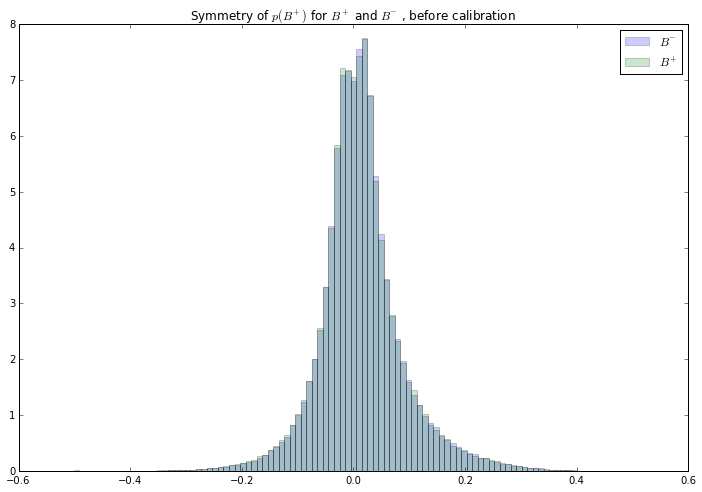

In [11]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2, 
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, before calibration')

#### KS distance

In [12]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

In [13]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.0049933391162730878)

((0, 1), (0, 1))

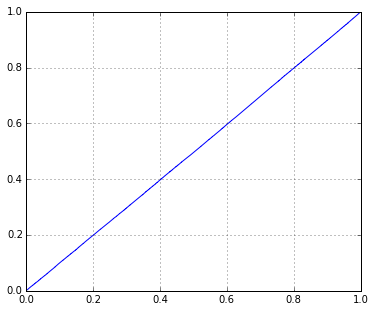

In [14]:
figsize(6, 5)
plot(fpr, tpr), grid()
xlim(0, 1), ylim(0, 1)

### after calibration

(<matplotlib.legend.Legend at 0xa62b290>, <matplotlib.text.Text at 0xa62b8d0>)

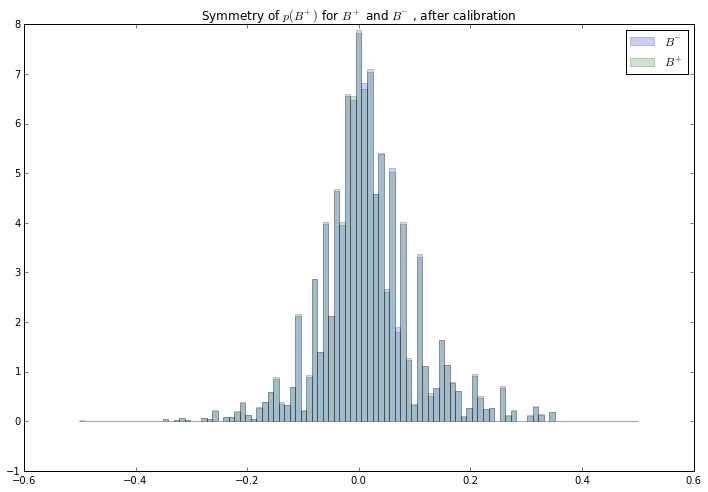

In [15]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob_calibrated[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2,
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, after calibration')

#### KS distance

In [16]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

In [17]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.0048414744746988481)

((0, 1), (0, 1))

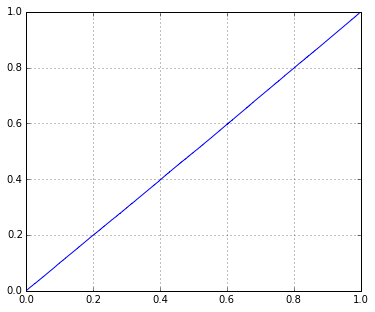

In [18]:
figsize(6, 5)
plot(fpr, tpr), grid()
xlim(0, 1), ylim(0, 1)

## D2 estimation with bootstrap calibration

In [19]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / get_N_B_events()

D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob, symmetrize=True)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging, PID less')

AUC 0.594400282797 5.25949851596e-07


In [20]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Inclusive tagging, PID less",72.397641,0.09872,0.030768,0.000353,2.22756,0.025731,57.419,0


In [21]:
result.to_csv('img/eff_tracking_SS.csv', header=True, index=False)

## Some plots

### Isotonic transformation, and its reverse (too check symmetry)

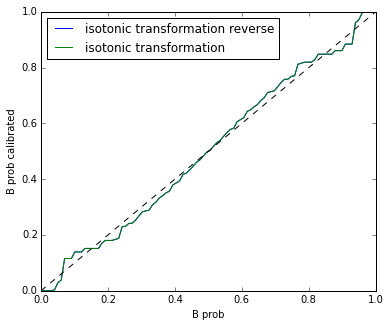

In [22]:
x = numpy.linspace(0, 1, 100)
plot(x, -(iso_reg1.transform((1-x)) + iso_reg2.transform((1-x))) / 2 + 1, label='isotonic transformation reverse')
plot(x, (iso_reg1.transform(x) + iso_reg2.transform(x)) / 2, label='isotonic transformation')
legend(loc='best')
plot([0, 1], [0, 1], "k--")
xlabel('B prob'), ylabel('B prob calibrated')
plt.savefig('img/iso_transformation_SS.png' , format='png')

### Mistag checking

In [23]:
from utils import get_N_B_events, compute_mistag

In [24]:
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

### before calibration

/moosefs/ipython_env/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


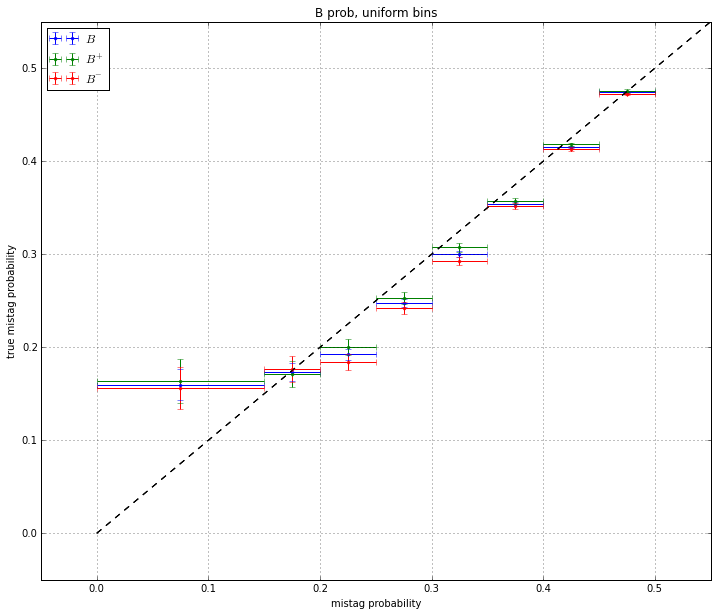

In [25]:
figsize(12, 10)
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins)
legend(loc='best')
title('B prob, uniform bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_uniform_SS.png' , format='png')

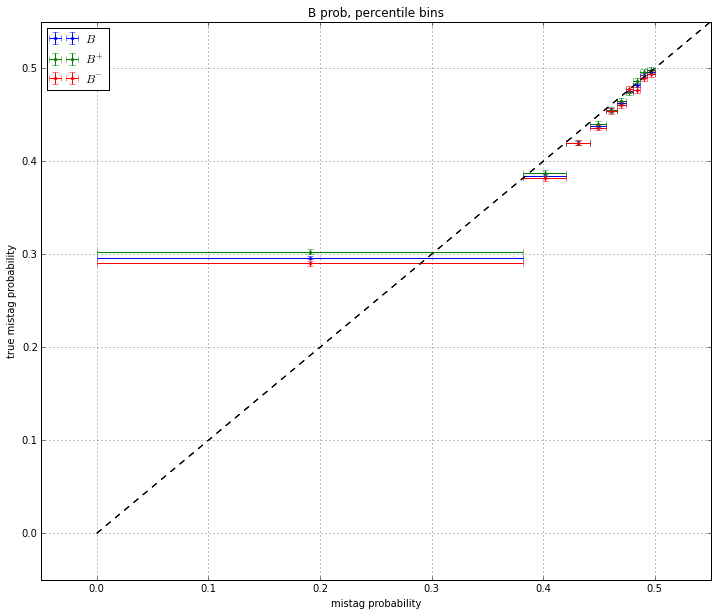

In [26]:
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False, bins=percentile_bins)
p1 = compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, bins=percentile_bins)
legend(loc='best')
title('B prob, percentile bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_percentile_SS.png' , format='png')

### after calibration

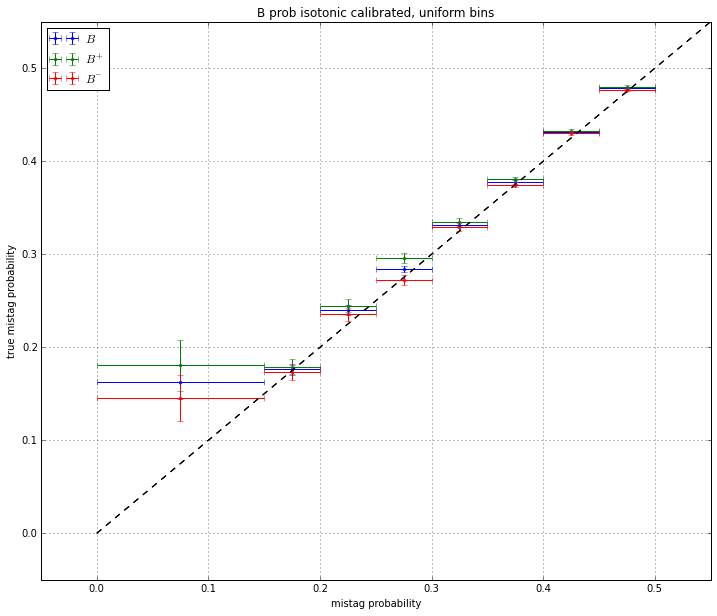

In [27]:
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins)
legend(loc='best')
title('B prob isotonic calibrated, uniform bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_iso_uniform_SS.png' , format='png')

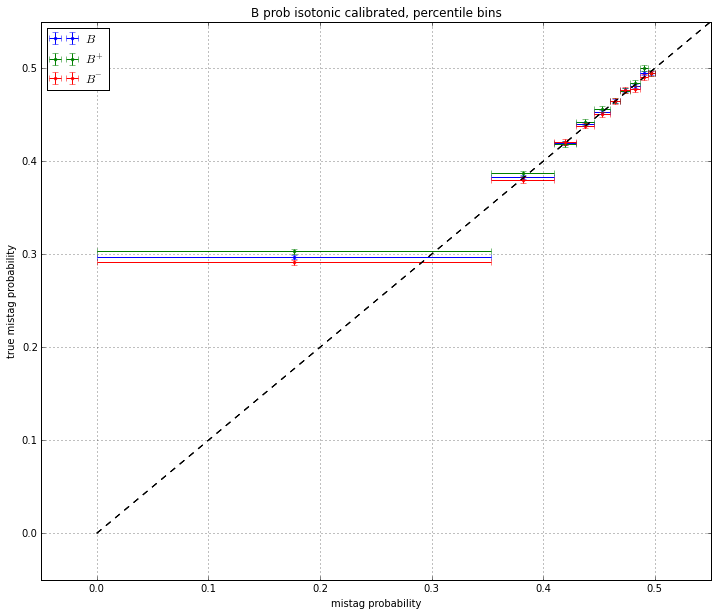

In [28]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')
plt.savefig('img/Bprob_calibration_check_iso_percentile_SS.png' , format='png')

In [29]:
print numpy.average((2*(Bprob - 0.5))**2, weights=Bweight) * tagging_efficiency * 100
print numpy.average((2*(Bprob_calibrated - 0.5))**2, weights=Bweight) * Bweight.sum() / get_N_B_events() * 100 

1.68503107259
2.23486767303
